
# SQLAlchemy-challenge - Part 1: Analyze and Explore the Climate Data

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


#### Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/bb/58xtq6zd03z6j840hj_gdn9h0000gn/T/ipykernel_20307/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

## Exploratory Precipitation Analysis

In [9]:
#Find what columns are in measurement as well as datetype
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print (c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = (session.query(measurement.date).order_by(measurement.date.desc()).first())

In [11]:
#print what is the most recent date in data set
recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
recent_date

# Calculate the date one year from the last date in data set.
yearago_date = dt.date(2017,8,23)-dt.timedelta(days=365)
yearago_date

# Perform a query to retrieve the data and precipitation scores
date_precipation = session.query(measurement.date, measurement.prcp)\
                .filter(measurement.date >= yearago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
yearago_date_df = pd.DataFrame(date_precipation, columns=['date', 'prcp'])

#Sort the DateFrame values by date
yearago_date_df = yearago_date_df.sort_values('date')


yearago_date_df = yearago_date_df.set_index('date')


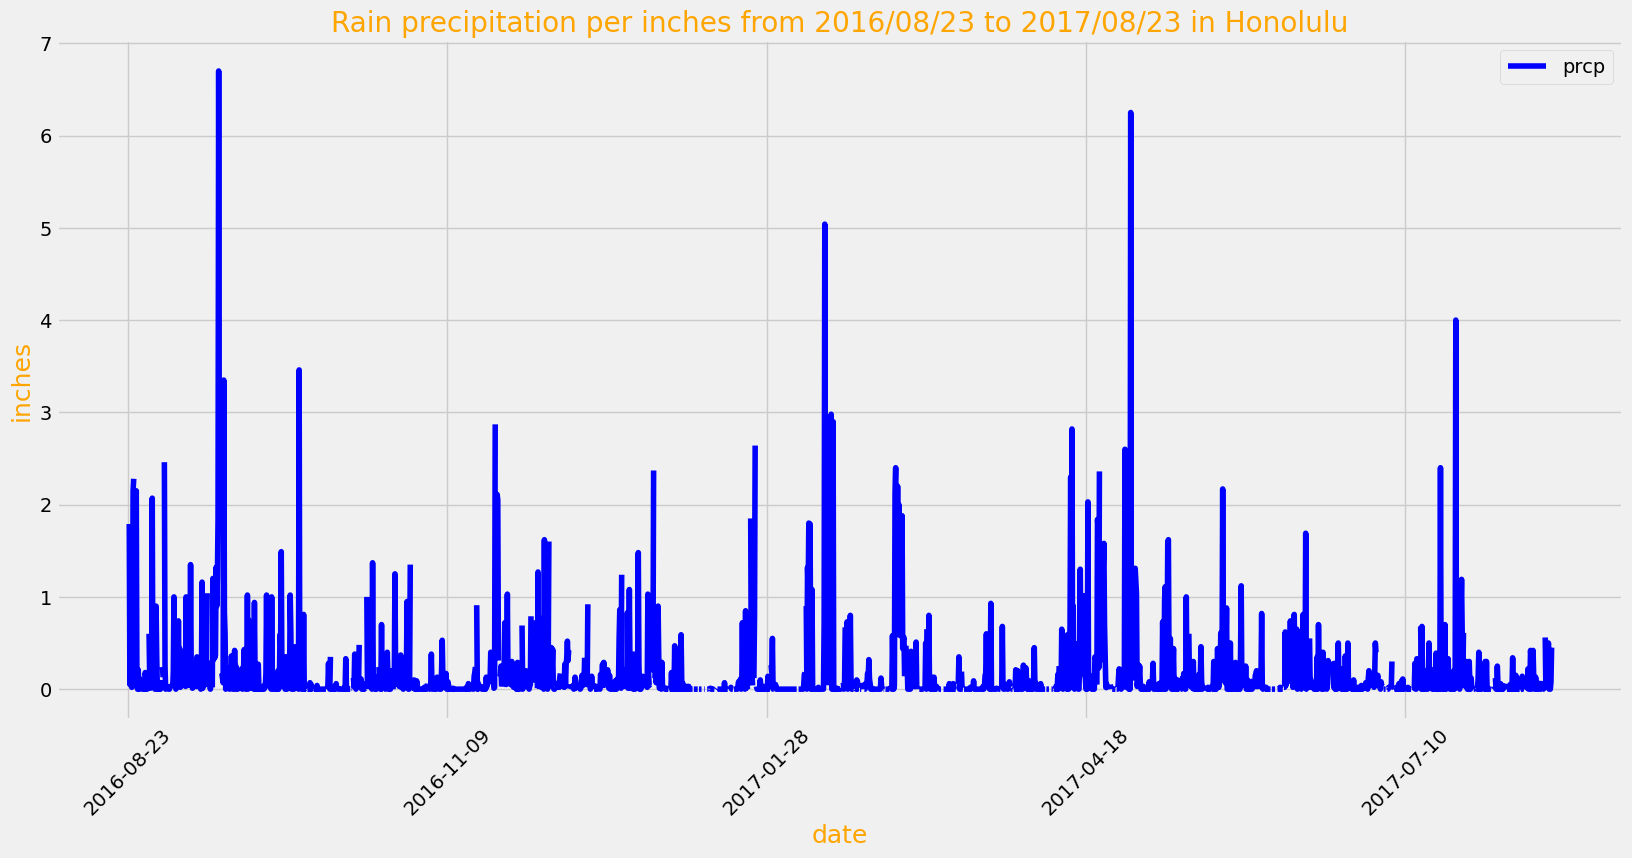

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
yearago_date_df.plot(alpha=1, figsize=(18,10),rot=45, color='blue')
plt.subplots_adjust(bottom=0.2)

#Plot labels
plt.xlabel('date',fontsize= 18, color='orange')
plt.ylabel('inches',fontsize= 18, color='orange' )
plt.title('Rain precipitation per inches from 2016/08/23 to 2017/08/23 in Honolulu', color = 'orange')

#Show plot and save result
plt.tight_layout
plt.savefig("/Users/jelenaraonic/UofTBootcamp/Homework/sqlalchemy-challenge/SurfsUp/Images/Figure1.png")
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
yearago_date_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [15]:
#Find what columns are in station as well as datetype
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print (c['name'], c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number of stations in the dataset
count_station = session.query(func.count(station.id)).all()
count_station

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).all()

# List the stations and their counts in descending order.
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
average_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'Most active station: "USC00519281", Lowest Temperature: {lowest_temp}, Highest Temperature: {highest_temp}, Average Temperature: {average_temp}')

Most active station: "USC00519281", Lowest Temperature: [(54.0,)], Highest Temperature: [(85.0,)], Average Temperature: [(71.66378066378067,)]


In [19]:
# Other way to get most active station 
most_active_stations[0][0]

'USC00519281'

In [20]:
# In another way using most active station an calculating lowest, highest and average temperature.
query_item = [func.min(measurement.tobs),func.max(measurement.tobs), func.avg(measurement.tobs)] 
session.query(*query_item).filter(measurement.station == most_active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

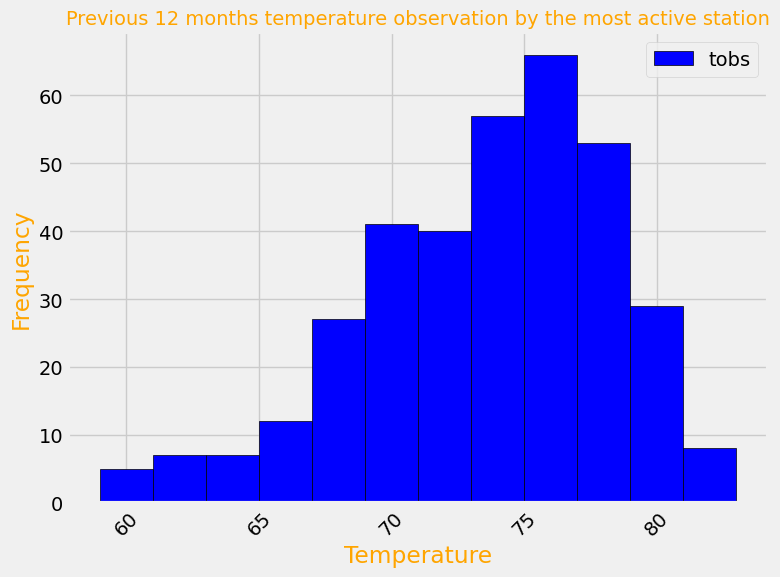

In [21]:
# Using the most active station id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results=session.query(measurement.station,measurement.tobs).\
                filter(measurement.station == 'USC00519281').\
                filter(measurement.date>= yearago_date).all()
temp_results_df = pd.DataFrame(temp_results)
temp_results_df.set_index('station',inplace=True)

#Create histogram with 12 bins
temp_results_df.plot.hist(bins=12,figsize=(8,6), rot=45, color="blue",edgecolor='black')

#Label the plot
plt.xlabel('Temperature', color='orange')
plt.ylabel('Frequency', color='orange')
plt.title('Previous 12 months temperature observation by the most active station',fontsize=14, color='orange')

#Show the plot and save the picture
plt.tight_layout()
plt.savefig("/Users/jelenaraonic/UofTBootcamp/Homework/sqlalchemy-challenge/SurfsUp/Images/Figure2.png")
plt.show()


### Close Session

In [22]:
# Close Session
session.close()